# Rayleigh-Benard instability

In this notebook, we visualize the Rayleigh-Benard instability in a two-dimensional thermal flow. We use the coupled schemes proposed by Pierre Lallemand and Li-Shi Luo in 
https://www.sciencedirect.com/science/article/pii/S0898122112004671?via%3Dihub

This scheme of a thermal fluid in the Boussinesq approximation is composed of 
* a $D_1Q_9$ for the hydrodynamic with a source term,
* a $D_1Q_5$ for the thermic.


In [1]:
import numpy as np
import sympy as sp
import pyLBM

%matplotlib notebook

<IPython.core.display.Javascript object>


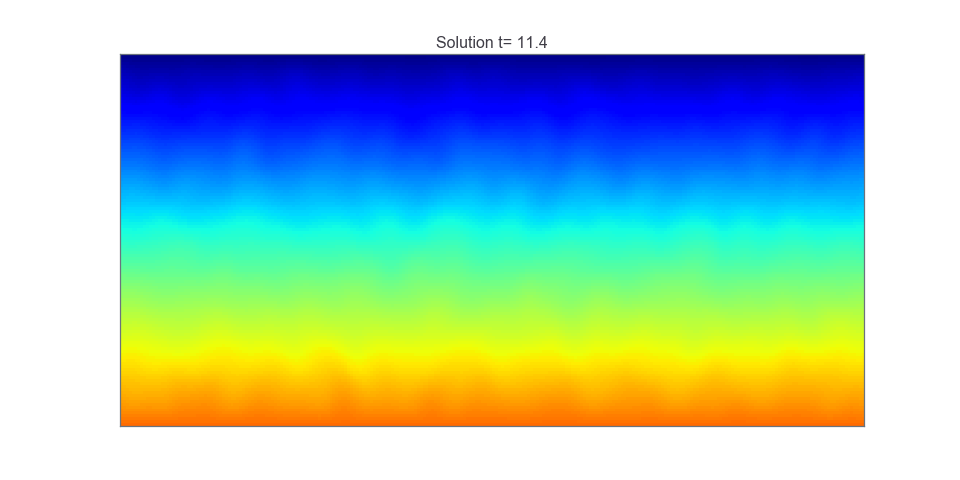

In [2]:
"""

Rayleigh-Benard instability simulated by
Navier-Stokes solver D2Q9 coupled to thermic solver D2Q5

"""
X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy, T = sp.symbols('rho, qx, qy, T')

def init_T(x, y):
    #return Td + (Tu-Td)/(ymax-ymin)*(y-ymin)
    return Td + (Tu-Td)/(ymax-ymin)*(y-ymin) + (Td-Tu) * (0.1*np.random.random_sample((x.shape[0],y.shape[1]))-0.05)

def bc_up(f, m, x, y):
    m[qx] = 0.
    m[qy] = 0.
    m[T] = Tu

def bc_down(f, m, x, y):
    np.random.seed(1)
    m[qx] = 0.
    m[qy] = 0.
    m[T] = Td# + (Td-Tu) * 5 * (0.1*np.random.random_sample((x.shape[0],1))-0.05)

# parameters
Tu = -0.5
Td =  0.5
xmin, xmax, ymin, ymax = 0., 2., 0., 1.
Ra = 2000
Pr = 0.71
Ma = 0.01
alpha = .005
dx = 1./128
la = 1. # velocity of the scheme
rhoo = 1.
g = 9.81

nu = np.sqrt(Pr*alpha*9.81*(Td-Tu)*(ymax-ymin)/Ra)
kappa = nu/Pr
eta = nu
snu = 1./(.5+3*nu)
seta = 1./(.5+3*eta)
sq = 8*(2-snu)/(8-snu)
se = seta
sf = [0., 0., 0., seta, se, sq, sq, snu, snu]
a = .5
skappa = 1./(.5+10*kappa/(4+a))
se = 1./(.5+np.sqrt(3)/3)
snu = se
sT = [0., skappa, skappa, se, snu]

dico = {
    'box': {
        'x': [xmin, xmax], 
        'y': [ymin, ymax], 
        'label':[-1, -1, 0, 1],
    },
    'space_step': dx,
    'scheme_velocity': la,
    'schemes':[
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials':[
                1, X, Y,
                3*(X**2+Y**2)-4,
                0.5*(9*(X**2+Y**2)**2-21*(X**2+Y**2)+8),
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': sf,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*(qx**2+qy**2),
                rho - 3*(qx**2+qy**2),
                -qx, -qy,
                qx**2 - qy**2, qx*qy
            ],
            'source_terms': {qy: alpha*g*T},
            'init': {rho: 1., qx: 0., qy: 0.},
        },
        {
            'velocities': list(range(5)),
            'conserved_moments': T,
            'polynomials': [1, X, Y, 5*(X**2+Y**2) - 4, (X**2-Y**2)],
            'equilibrium': [T, T*qx, T*qy, a*T, 0.],
            'relaxation_parameters': sT,
            'init': {T: (init_T,)},
        },
    ],
    'boundary_conditions': {
        0: {
            'method': {
                0: pyLBM.bc.Bouzidi_bounce_back, 
                1: pyLBM.bc.Bouzidi_anti_bounce_back,
            }, 
            'value': bc_down
        },
        1: {
            'method': {
                0: pyLBM.bc.Bouzidi_bounce_back, 
                1: pyLBM.bc.Bouzidi_anti_bounce_back,
            }, 
            'value': bc_up
        },
    },
    'generator': "cython",
}

sol = pyLBM.Simulation(dico)

x, y = sol.domain.x, sol.domain.y

viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig(figsize = (12,6))
ax = fig[0]
ax.grid(visible = False)
ax.xaxis_set_visible(False)
ax.yaxis_set_visible(False)
image = ax.image(sol.m[T].T, cmap='jet', clim=[Tu, Td+.25])

def update(iframe):
    nrep = 16
    for i in range(nrep):
        sol.one_time_step()
    image.set_data(sol.m[T].T)
    ax.title = "Solution t={0:5.1f}".format(sol.t)

# run the simulation
fig.animate(update, interval=10)
fig.show()
